In [37]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
print(torch.__version__)

2.7.0+cu128


In [ ]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [19]:
train_df = pd.read_csv('data/deepfake-classification-unibuc/train.csv')
val_df = pd.read_csv('data/deepfake-classification-unibuc/validation.csv')

In [31]:
train_df[:3]

,image_id,label
0,532de967-c8fb-49a6-9a8c-3c32cfa93d3e,0
1,c0519e94-1422-405c-a847-ce726f4a13cf,2
2,13a99838-2919-4b79-b9fd-bce8f0e59e09,2


In [9]:
train_df['label'].value_counts()

label
0    2500
2    2500
3    2500
4    2500
1    2500
Name: count, dtype: int64

In [11]:
val_df['label'].value_counts()

label
3    250
0    250
2    250
4    250
1    250
Name: count, dtype: int64

In [5]:
def show_class_images(csv_path, img_dir, target_class=4, num_images=3):
    df = pd.read_csv(csv_path)
    # get random sample of images with target class label
    class4_df = df[df['label'] == target_class].sample(num_images, random_state=42)

    plt.figure(figsize=(12, 4))
    for i, row in enumerate(class4_df.itertuples()):
        img_path = os.path.join(img_dir, row.image_id + '.png')
        image = Image.open(img_path).convert("RGB")
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(f"Class {target_class}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

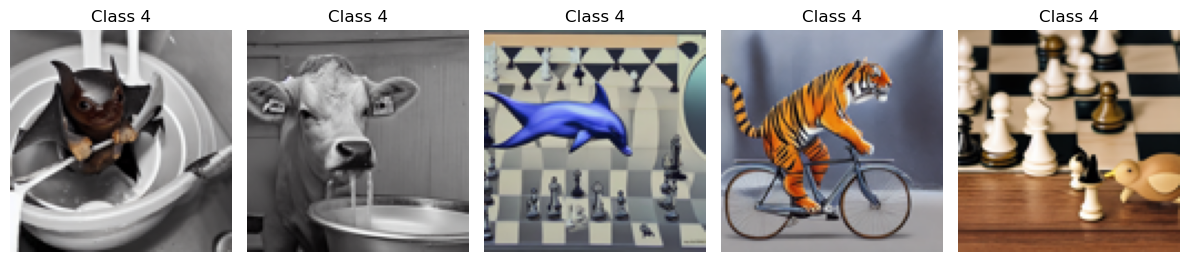

In [13]:
show_class_images("data/deepfake-classification-unibuc/train.csv", "data/deepfake-classification-unibuc/train", target_class=4, num_images=5)

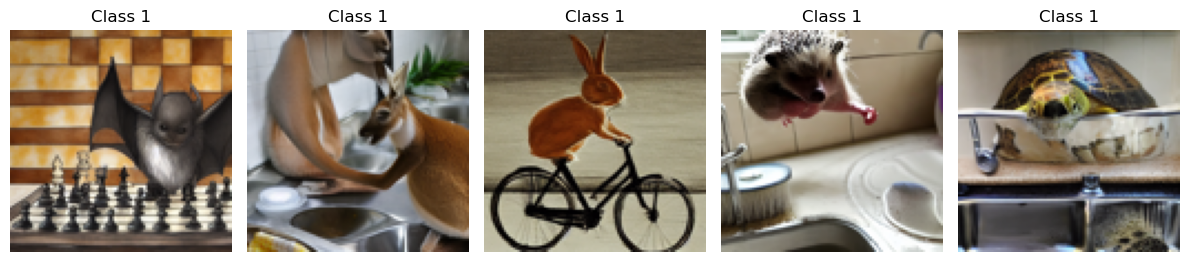

In [15]:
show_class_images("data/deepfake-classification-unibuc/train.csv", "data/deepfake-classification-unibuc/train", target_class=1, num_images=5)

In [72]:
import os
def load_images(img_dir, cur_df):
    images = []
    labels = []
    # iterate over files in directory
    for file_name in os.listdir(img_dir):
        # if file is an image
        if file_name.endswith('.png'):
            img = Image.open(os.path.join(img_dir, file_name))
            # before appending image, I flatten it
            # to be able to pass it it svm model
            images.append(np.array(img).reshape(1, -1))
            # get image label corresponding to current image (filename == id)
            labels.append(cur_df[cur_df['image_id']==file_name[:-4]]['label'])
    # return numpy arrays, 1 for images, 1 for labels
    # use squeeze to get rid of extra dimension
    # since svm.SVC expects <=2D input
    return np.array(images).squeeze(axis=1), np.array(labels).squeeze(axis=1)
    

In [25]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [74]:
X_train, y_train = load_images("data/deepfake-classification-unibuc/train", train_df)
X_val, y_val = load_images("data/deepfake-classification-unibuc/validation", val_df)

In [78]:
y_train[:7]

array([0, 1, 0, 1, 0, 2, 3], dtype=int64)

In [80]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [82]:
svc = SVC(kernel='rbf', gamma='auto')
svc.fit(X_train_scaled, y_train)

SVC(gamma='auto')

In [88]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = svc.predict(X_val_scaled)
acc = accuracy_score(y_pred=y_pred, y_true=y_val)
svc_report = pd.DataFrame(classification_report(y_pred=y_pred, y_true=y_val, output_dict=True))

In [90]:
acc
# not bad for non CNN model

0.6336

In [92]:
svc_report

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.664179,0.506073,0.637993,0.915612,0.429224,0.6336,0.630616,0.630616
recall,0.712000,0.500000,0.712000,0.868000,0.376000,0.6336,0.633600,0.633600
f1-score,0.687259,0.503018,0.672968,0.891170,0.400853,0.6336,0.631054,0.631054
support,250.000000,250.000000,250.000000,250.000000,250.000000,0.6336,1250.000000,1250.000000


In [94]:
# 3 instances of this class for train, validation and test
# train, validation and test each has own folder
class DeepfakeDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, is_test=False):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        # adds transforms to image
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 0]
        # image file names correspond to their ids in csv data
        img_path = os.path.join(self.img_dir, img_id + ".png")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # when testing no labels, need image id
        if self.is_test:
            return image, img_id
        # when training or validating need labels
        else:
            label = int(self.data.iloc[idx, 1])
            return image, label


In [102]:
# CNN consists of 3 blocks each of them:
# Performs 2 convolutions and 2 ReLU activation functions
# to detect non-linear dependencies
# uses max pool which downsamples image
# reducing image height and width by factor of 2
# dropout layers help reducing overfitting
class DeepfakeNet(nn.Module):
    def __init__(self, num_classes=5):
        super(DeepfakeNet, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   
            nn.Dropout(0.25)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  
            nn.Dropout(0.3)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28 → 14
            nn.Dropout(0.4)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = self.global_pool(self.conv_block3(self.conv_block2(self.conv_block1(x))))
        # x = x.view(x.size(0),-1)
        # x = self.fc(x)
        return x


In [124]:
# some common transformations of original train images
# helps for data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
   
    transforms.RandAugment(num_ops=2),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                     std=[0.5, 0.5, 0.5]),
    CenterCutout(cutout_size=30, p=0.3)

])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5],
                     #std=[0.5, 0.5, 0.5])
])


In [98]:
import torch
import torchvision.transforms.functional as TF

class CenterCutout:
    def __init__(self, cutout_size=30, p=0.5):
        self.cutout_size = cutout_size
        self.p = p

    def __call__(self, img):
        if torch.rand(1).item() > self.p:
            return img  # don't apply

        _, h, w = img.shape
        cx, cy = w // 2, h // 2
        x1 = max(cx - self.cutout_size // 2, 0)
        y1 = max(cy - self.cutout_size // 2, 0)
        x2 = min(cx + self.cutout_size // 2, w)
        y2 = min(cy + self.cutout_size // 2, h)

        img[:, y1:y2, x1:x2] = 0  # apply black cutout at center
        return img


In [104]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    for imgs, labels in tqdm(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        # optimizer gradient accumulates with every iteration, so I reset it to 0
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        # propagate loss backwards to calculate gradient
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # return average training loss per mini batch
    return running_loss / len(dataloader)

In [106]:
def evaluate(model, dataloader, device):
    model.eval()
    preds, truths = [], []
    with torch.inference_mode():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            pred_labels = outputs.argmax(dim=1).cpu().numpy()
            preds.extend(pred_labels)
            truths.extend(labels.numpy())
    acc = accuracy_score(truths, preds)
    return acc 

In [108]:
# same as evaluate, but returns also truths and preds 
# for statistics such as classification report
# and confusion matrix
def evaluate_stats(model, dataloader, device):
    model.eval()
    preds, truths = [], []
    with torch.inference_mode():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            # take class with higher predicted probability / logit
            pred_labels = outputs.argmax(dim=1).cpu().numpy()
            preds.extend(pred_labels)
            truths.extend(labels.numpy())
    acc = accuracy_score(truths, preds)
    return acc, truths, preds 

In [13]:
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_ids = []
    with torch.no_grad():
        for imgs, ids in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            # output of model is in logits by default
            # I take argmax of logits to get class with higher probability
            # since higher logit => higher prediction probability
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_ids.extend(ids)
    return pd.DataFrame({"image_id": all_ids, "label": all_preds})


In [ ]:
# train model

In [164]:
train_ds = DeepfakeDataset("data/deepfake-classification-unibuc/train.csv", "data/deepfake-classification-unibuc/train", transform=train_transforms)
val_ds = DeepfakeDataset("data/deepfake-classification-unibuc/validation.csv", "data/deepfake-classification-unibuc/validation", transform=val_transforms)
test_ds = DeepfakeDataset("data/deepfake-classification-unibuc/test.csv", "data/deepfake-classification-unibuc/test", transform=val_transforms, is_test=True)

In [166]:
# Use mini batches to speed up training
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [114]:
model = DeepfakeNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DeepfakeNet(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [120]:
model.load_state_dict(torch.load('model0_sgd.pth'))

<All keys matched successfully>

In [148]:
# boosting class 4 recall
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 2.7])
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

In [231]:
for epoch in range(4):
    loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    acc = evaluate(model, val_loader, device)
    if acc>0.92:
        torch.save(model.state_dict(), 'model0_improved.pth')
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Val Acc={acc:.4f}")
    scheduler.step(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:21<00:00,  4.82it/s]


Epoch 1: Loss=0.2987, Val Acc=0.9200


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:19<00:00,  4.89it/s]


Epoch 2: Loss=0.2927, Val Acc=0.9232


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:25<00:00,  4.56it/s]


Epoch 3: Loss=0.2933, Val Acc=0.9216


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:22<00:00,  4.73it/s]


Epoch 4: Loss=0.3011, Val Acc=0.9208


In [211]:
submission_df = predict(model, test_loader, device)
submission_df.to_csv("submission2.csv", index=False)

In [233]:
#torch.save(model.state_dict(), 'model2_improved_class4_vbest1.pth')

In [134]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

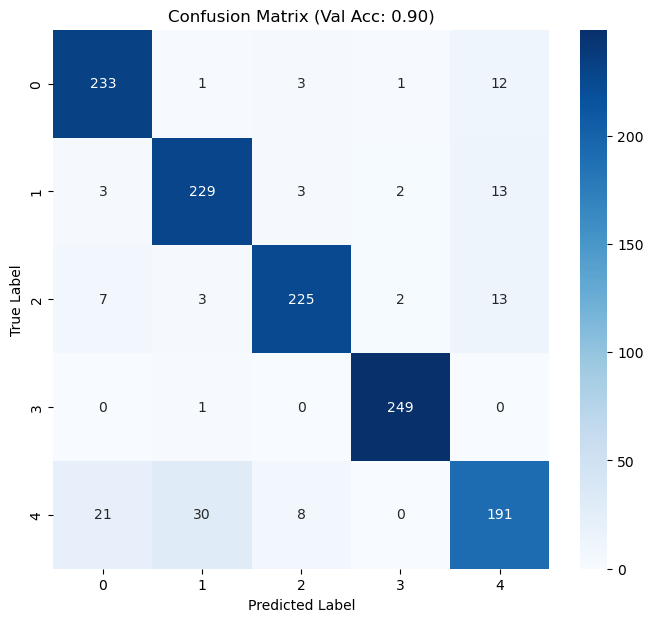

In [146]:
val_acc, truths, preds = evaluate_stats(model, val_loader, device)
cm = confusion_matrix(truths, preds)
plt.figure(figsize=(8, 7))
conf_mat = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Val Acc: {val_acc:.2f})')
plt.show()
conf_mat.figure.savefig('conf_mat0.png')

In [130]:
val_acc, truths, preds = evaluate_stats(model, val_loader, device)
report_df = pd.DataFrame(classification_report(y_pred=preds, y_true=truths, output_dict=True))
report_df

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.882576,0.867424,0.941423,0.980315,0.834061,0.9016,0.90116,0.90116
recall,0.932000,0.916000,0.900000,0.996000,0.764000,0.9016,0.90160,0.90160
f1-score,0.906615,0.891051,0.920245,0.988095,0.797495,0.9016,0.90070,0.90070
support,250.000000,250.000000,250.000000,250.000000,250.000000,0.9016,1250.00000,1250.00000


In [150]:
# i give more weight to class4 to boost its recall
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 2.5], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [162]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomRotation(10),
    transforms.RandAugment(num_ops=2),
    #transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                     std=[0.5, 0.5, 0.5]),
    CenterCutout(cutout_size=30, p=0.3) # cut some square area in center

])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                     std=[0.5, 0.5, 0.5])
])


In [152]:
class DeepfakeNet2(nn.Module):
    def __init__(self, num_classes=5):
        super(DeepfakeNet2, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 3 input rgb channels
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # adjust input for next layer
            nn.ReLU(),
            nn.MaxPool2d(2),  # reduce image dimensions by factor of 2
            nn.Dropout(0.25)  # helps reduce overfitting
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  
            nn.Dropout(0.2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Dropout(0.2)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # 14x14 → 1x1
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [156]:
model1 = DeepfakeNet2()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.load_state_dict(torch.load('model2_improved_class4_v7.pth'))
model1.to(device)

DeepfakeNet2(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [158]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

In [151]:
for epoch in range(7):
    loss = train_one_epoch(model1, train_loader, optimizer, criterion, device)
    acc = evaluate(model1, val_loader, device)
    if acc>0.92:
        torch.save(model1.state_dict(), 'model1_improved.pth')
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Val Acc={acc:.4f}")
    scheduler.step(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:06<00:00,  5.89it/s]


Epoch 1: Loss=0.1809, Val Acc=0.9208


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:06<00:00,  5.90it/s]


Epoch 2: Loss=0.1842, Val Acc=0.9240


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:06<00:00,  5.89it/s]


Epoch 3: Loss=0.1807, Val Acc=0.9240


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:06<00:00,  5.86it/s]


Epoch 4: Loss=0.1802, Val Acc=0.9216


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:06<00:00,  5.85it/s]


Epoch 5: Loss=0.1739, Val Acc=0.9192


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:07<00:00,  5.83it/s]


Epoch 6: Loss=0.1681, Val Acc=0.9192


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:07<00:00,  5.82it/s]


Epoch 7: Loss=0.1736, Val Acc=0.9280


In [467]:
from torch.utils.data import WeightedRandomSampler

df = pd.read_csv("data/deepfake-classification-unibuc/train.csv")
labels = df["label"].values
weights = torch.ones_like(torch.tensor(labels), dtype=torch.float)
weights[labels == 4] = 2.0  
weights[labels == 1] = 1.4
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# I tried weighted sampler to make model learn class 4 better but accuracy dropped significantly (below 90%)

In [168]:
val_acc, truths, preds = evaluate_stats(model1, val_loader, device)
report_df = pd.DataFrame(classification_report(y_pred=preds, y_true=truths, output_dict=True))
report_df

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.910506,0.904943,0.959514,1.000000,0.880342,0.9312,0.931061,0.931061
recall,0.936000,0.952000,0.948000,0.996000,0.824000,0.9312,0.931200,0.931200
f1-score,0.923077,0.927875,0.953722,0.997996,0.851240,0.9312,0.930782,0.930782
support,250.000000,250.000000,250.000000,250.000000,250.000000,0.9312,1250.000000,1250.000000


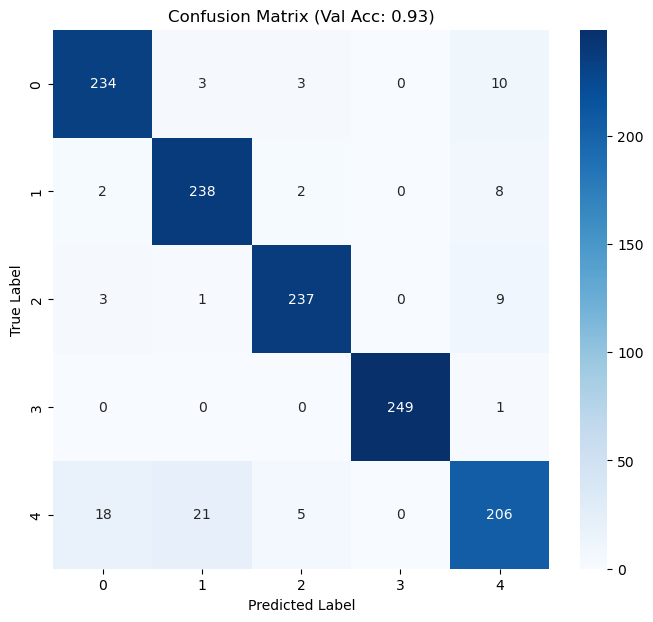

In [170]:
val_acc, truths, preds = evaluate_stats(model1, val_loader, device)
cm = confusion_matrix(truths, preds)
plt.figure(figsize=(8, 7))
conf_mat = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Val Acc: {val_acc:.2f})')
plt.show()
#conf_mat.figure.savefig('conf_mat0.png')

In [172]:
# popular VGG16 CNN architecture for image classification
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer13(self.layer12(self.layer11(self.layer10(self.layer9(self.layer8(self.layer7(self.layer6(self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))))))))))
        out = self.adaptive_pool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [176]:
model2 = VGG16()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.load_state_dict(torch.load('vgg_v1_best'))
model2.to(device)

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [231]:
for epoch in range(4):
    loss = train_one_epoch(model2, train_loader, optimizer, criterion, device)
    acc = evaluate(model2, val_loader, device)
    if acc>0.92:
        torch.save(model2.state_dict(), 'model2_improved.pth')
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Val Acc={acc:.4f}")
    scheduler.step(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:21<00:00,  4.82it/s]


Epoch 1: Loss=0.2987, Val Acc=0.9200


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:19<00:00,  4.89it/s]


Epoch 2: Loss=0.2927, Val Acc=0.9232


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:25<00:00,  4.56it/s]


Epoch 3: Loss=0.2933, Val Acc=0.9216


100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [01:22<00:00,  4.73it/s]


Epoch 4: Loss=0.3011, Val Acc=0.9208


In [178]:
val_acc, truths, preds = evaluate_stats(model2, val_loader, device)
report_df = pd.DataFrame(classification_report(y_pred=preds, y_true=truths, output_dict=True))
report_df

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.913386,0.926829,0.928571,0.995968,0.84,0.9208,0.920951,0.920951
recall,0.928000,0.912000,0.936000,0.988000,0.84,0.9208,0.920800,0.920800
f1-score,0.920635,0.919355,0.932271,0.991968,0.84,0.9208,0.920846,0.920846
support,250.000000,250.000000,250.000000,250.000000,250.00,0.9208,1250.000000,1250.000000


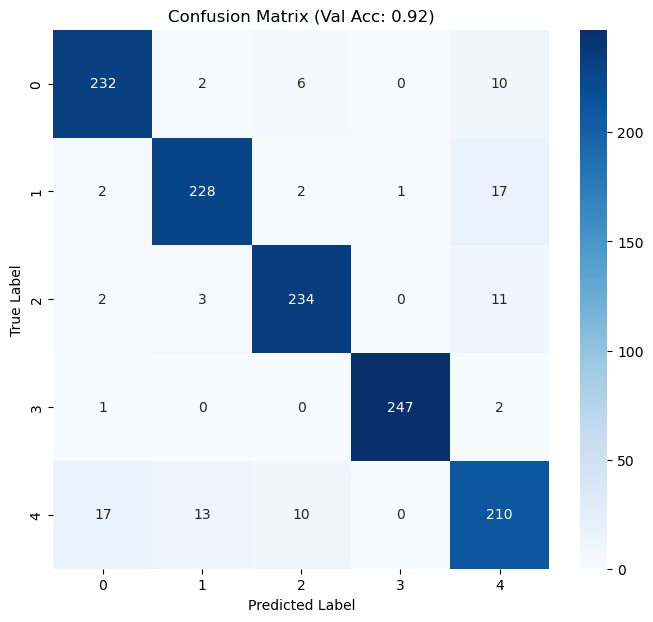

In [180]:
val_acc, truths, preds = evaluate_stats(model2, val_loader, device)
cm = confusion_matrix(truths, preds)
plt.figure(figsize=(8, 7))
conf_mat = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Val Acc: {val_acc:.2f})')
plt.show()
#conf_mat.figure.savefig('conf_mat0.png')

In [ ]:
# trying ensemble model of model1 (DeepFakeNet2) and model2 (VGG16)

In [182]:
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, num_classes=5):
        super(EnsembleModel, self).__init__()
        self.model1 = model1  # DeepfakeNet2
        self.model2 = model2  # VGG16

        for param in self.model1.parameters():
            param.requires_grad = False
        for param in self.model2.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(num_classes * 2, 64), # 5 logits from model1
                                            # concatenated with 5 logits from model2
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x1 = self.model1(x)  
        x2 = self.model2(x)  

        x_cat = torch.cat([x1, x2], dim=1) # concatenate logits of 2 models  
        out = self.classifier(x_cat)
        return out


In [184]:
model1.eval()
model2.eval()
model = EnsembleModel(model1, model2, num_classes=5).to(device)
model.load_state_dict(torch.load('ensemble_bestval2'))

<All keys matched successfully>

In [ ]:
weights = torch.tensor([1.9, 1.0, 1, 1.0, 1.7])
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

In [ ]:
for epoch in range(10):
    loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    acc = evaluate(model, val_loader, device)
    if acc>0.92:
        torch.save(model.state_dict(), 'ensemble_improved.pth')
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Val Acc={acc:.4f}")
    scheduler.step(loss)

In [186]:
val_acc, truths, preds = evaluate_stats(model, val_loader, device)
report_df = pd.DataFrame(classification_report(y_pred=preds, y_true=truths, output_dict=True))
report_df

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.929412,0.936,0.947791,1.0,0.865854,0.936,0.935811,0.935811
recall,0.948000,0.936,0.944000,1.0,0.852000,0.936,0.936000,0.936000
f1-score,0.938614,0.936,0.945892,1.0,0.858871,0.936,0.935875,0.935875
support,250.000000,250.000,250.000000,250.0,250.000000,0.936,1250.000000,1250.000000


In [188]:
model.load_state_dict(torch.load('ensemble_bestval8'))
# this ensemble model has lower validation accuracy but higher test score 

<All keys matched successfully>

In [190]:
val_acc, truths, preds = evaluate_stats(model, val_loader, device)
report_df = pd.DataFrame(classification_report(y_pred=preds, y_true=truths, output_dict=True))
report_df

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.939516,0.936255,0.954733,1.0,0.841085,0.9336,0.934318,0.934318
recall,0.932000,0.940000,0.928000,1.0,0.868000,0.9336,0.933600,0.933600
f1-score,0.935743,0.938124,0.941176,1.0,0.854331,0.9336,0.933875,0.933875
support,250.000000,250.000000,250.000000,250.0,250.000000,0.9336,1250.000000,1250.000000


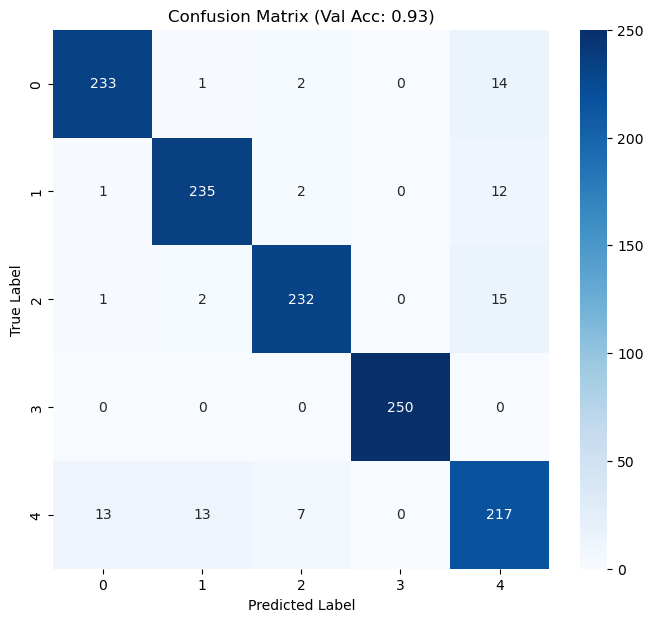

In [192]:
val_acc, truths, preds = evaluate_stats(model, val_loader, device)
cm = confusion_matrix(truths, preds)
plt.figure(figsize=(8, 7))
conf_mat = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Val Acc: {val_acc:.2f})')
plt.show()
#conf_mat.figure.savefig('conf_mat0.png')

In [ ]:
submission_df = predict(model, test_loader, device)
submission_df.to_csv("submission.csv", index=False)

In [17]:
!jupyter nbconvert --to script DeepFakeUnibuc_py.ipynb

[NbConvertApp] Converting notebook DeepFakeUnibuc_py.ipynb to script
[NbConvertApp] Writing 24214 bytes to DeepFakeUnibuc_py.py


In [15]:
!jupyter nbconvert --version

7.16.4
